In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install transformers
!pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.m

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [5]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [6]:
import random
random.seed(42)
galleries = ['animal','tree']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen


In [7]:
def remove_words(sentence, word):
    return ' '.join([w.replace(word, '') for w in sentence.split()])
    # return ' '.join([w for w in sentence.split() if w != word])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장','.jpg','.png','.txt','.gif']#['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [8]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [9]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [10]:
from transformers import AutoModel, AutoTokenizer
from umap import UMAP
# umap_model = UMAP(random_state=42)
# umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# model = AutoModel.from_pretrained("klue/bert-base")
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
# from kobert_tokenizer import KoBERTTokenizer
# tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
# import torch
# from transformers import BertModel
# model = BertModel.from_pretrained('skt/kobert-base-v1')

In [11]:
# class CustomTokenizer:
#   def __init__(self, tokenizer):
#     self.tokenizer = tokenizer
#   # def __call__(self, target):
#   #   return self.tokenizer.tokenize(target)
#   def __call__(self, target):
#     tokens = self.tokenizer.tokenize(target)
#     if len(tokens)==0:
#       return []
#     if isinstance(tokens[0], str):
#       indices = [i for i, token in enumerate(tokens) if not token.startswith('##')]
#       tokens = [tokens[i] for i in indices]
#     elif isinstance(tokens[0][0], str):
#       for j in range(len(tokens)):
#         indices = [i for i, token in enumerate(tokens[j]) if not token.startswith('##')]
#         tokens[j] = [tokens[j][i] for i in indices]
#     return tokens

In [12]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# custom_tokenizer = CustomTokenizer(tokenizer)
# # vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=3000)
# vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=3000)

In [13]:
# from umap import UMAP
# from hdbscan import HDBSCAN

# umap_model = UMAP(n_neighbors=5, n_components=5, metric='cosine', low_memory=False)
# hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)

In [14]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          # ctfidf_model=ctfidf_model,
                          top_n_words=1)
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [15]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)
# for i in lst:
#   print(i)

생성된 주제의 수: 99
햄스터
신엽
이거
귀여워
꽃이
물을
식쇼
잎이
햇빛
뿌리가
터널
식물등
병원
사료
식물
쥐친구
거미줄
흙에
이름이
찢어진
핸들링
꽃이에요
이름이
보스터
잠자는쥐
고양이
냄새
나무
귀여운
동물
코코넛
쥐가
쳇바퀴
서울
우리집
로보쿤
모래
발근제좀
뚱땡정글
그릇
비둘기
마시는
케이지
토마토
엉덩이가
사진
식물
잎이
맛있음
지하부
화장실
플로리다
기니피그
유혈목이
끓인
알로카시아
원숭이
토분
일베
레몬
수컷이
돼지
딸기
뽀뽀
냉장고를
올리브
강아지
온실
분갈이
블루베리
유튜브
빨리
거북이
사진
볼따구로
피그미다람쥐
나무위키
고양이
아이스크림
공간이
갤러
ㅇㅇ
벌레인지
생태계교란
베고니아
멍청햄
김나나
상어
흑설기와
은신처에서
높이
제라늄
버섯이
아디안텀처럼
개구리
불려야
피는지
미국
코코넛


In [17]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

In [18]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:01<00:00, 84.65it/s]


In [19]:
# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
# hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail, linkage_function=linkage_function)

In [20]:
bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [21]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
97,196,햄스터,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",194,근데,195,햄스터,1.557082
96,195,햄스터,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17,...",189,햄스터,121,이름이,1.278218
95,194,근데,"[12, 13, 15, 16, 19, 20, 21, 23, 24, 25, 26, 2...",183,냄새,193,나무위키,1.223802
94,193,나무위키,"[16, 19, 21, 23, 24, 25, 28, 29, 30, 33, 34, 3...",192,고양이,191,나무위키,1.154916
93,192,고양이,"[16, 19, 21, 25, 28, 29, 33, 37, 40, 43, 44, 4...",187,사진,103,고양이,1.152893
...,...,...,...,...,...,...,...,...
4,103,고양이,"[25, 77]",25,고양이,77,고양이,0.763412
3,102,햄스터,"[0, 2]",0,햄스터,2,이거,0.719822
2,101,물을,"[5, 9]",9,뿌리가,5,물을,0.718083
1,100,꽃이,"[1, 4]",4,꽃이,1,신엽,0.652926


In [22]:
# bertopic_model_embed_token.visualize_heatmap()

In [23]:
tree = bertopic_model_embed_token.get_topic_tree(hierarchical_topics)

In [24]:
# print(tree)

.
├─근데
│    ├─냄새
│    │    ├─냄새
│    │    │    ├─모래
│    │    │    │    ├─■──화장실 ── Topic: 50
│    │    │    │    └─■──모래 ── Topic: 36
│    │    │    └─■──냄새 ── Topic: 26
│    │    └─핸들링
│    │         ├─쥐친구
│    │         │    ├─쥐친구
│    │         │    │    ├─■──쥐친구 ── Topic: 15
│    │         │    │    └─■──쥐가 ── Topic: 31
│    │         │    └─쳇바퀴
│    │         │         ├─■──쳇바퀴 ── Topic: 32
│    │         │         └─■──은신처에서 ── Topic: 89
│    │         └─병원
│    │              ├─병원
│    │              │    ├─■──병원 ── Topic: 12
│    │              │    └─핸들링
│    │              │         ├─■──핸들링 ── Topic: 20
│    │              │         └─■──사료 ── Topic: 13
│    │              └─■──볼따구로 ── Topic: 74
│    └─나무위키
│         ├─고양이
│         │    ├─사진
│         │    │    ├─사진
│         │    │    │    ├─사진
│         │    │    │    │    ├─■──사진 ── Topic: 73
│         │    │    │    │    └─■──사진 ── Topic: 45
│         │    │    │    └─알로카시아
│         │    │    │         ├─알로카시아
│      

In [25]:
df = hierarchical_topics

selected_topics_ids = set()

for index, row in df[df['Distance'] >= 1].iterrows():
    left_child = df[df['Parent_ID'] == row['Child_Left_ID']]
    if not left_child.empty and left_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Left_ID'])

    right_child = df[df['Parent_ID'] == row['Child_Right_ID']]
    if not right_child.empty and right_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Right_ID'])
selected_topics_ids = list(selected_topics_ids)

['165', '140', '139', '162', '131', '129', '159', '168', '147', '134', '152', '130', '111', '166', '146', '121', '136', '157', '161', '103', '164', '110', '155', '151', '163', '167', '116']


In [26]:
selected_topic_names=[]
for topic_id in selected_topics_ids:
    topic_name = df[df['Parent_ID'] == topic_id]['Parent_Name'].iloc[0]
    selected_topic_names.append(topic_name)

ID: 165, Name: 알로카시아
ID: 140, Name: 잎이
ID: 139, Name: 피는지
ID: 162, Name: 잠자는쥐
ID: 131, Name: 케이지
ID: 129, Name: 병원
ID: 159, Name: 올리브
ID: 168, Name: 쥐친구
ID: 147, Name: 기니피그
ID: 134, Name: 식물
ID: 152, Name: 플로리다
ID: 130, Name: 냄새
ID: 111, Name: 햄스터
ID: 166, Name: 분갈이
ID: 146, Name: 유혈목이
ID: 121, Name: 이름이
ID: 136, Name: 끓인
ID: 157, Name: 생태계교란
ID: 161, Name: 나무위키
ID: 103, Name: 고양이
ID: 164, Name: 돼지
ID: 110, Name: 로보쿤
ID: 155, Name: 우리집
ID: 151, Name: 코코넛
ID: 163, Name: 제라늄
ID: 167, Name: 너무
ID: 116, Name: 사진


In [27]:
!pip install fasttext
import fasttext
from sklearn.cluster import KMeans
import numpy as np
from gensim import models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199769 sha256=fc87af21f16a25fdaae6327a5f567782002ba5cb0f4598627b91d84ee361d3a9
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [29]:
model_path = '/content/drive/MyDrive/jolnon/cc.ko.150.bin'

m_fasttext = models.fasttext.load_facebook_model(model_path)

ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa1\x9c'; replacing invalid characters, using '\\xed\\xa1\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb0\x80'; replacing invalid characters, using '\\xed\\xb0\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa7\x80'; replacing invalid characters, using '\\xed\\xa7\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb8\xb0'; replacing invalid characters, using '\\xed\\xb8\\xb0'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa0\x9c'; replacing invalid characters, using '\\xed\\xa0\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa6\xac'; replacing invalid characters, using '\\xed\\xa6\\xac'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb3\xb5'; replacing invalid characters, using '\\xed\\xb

In [45]:
embeddings = [m_fasttext.wv[selected_topic_names[i]] for i in range(len(selected_topic_names))]
embed_ids = [selected_topics_ids[i] for i in range(len(selected_topic_names))]

embeddings = np.array(embeddings)

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)

clustered_topics = [[] for _ in range(n_clusters)]
clustered_topics_name = [[] for _ in range(n_clusters)]

for i, label in enumerate(kmeans.labels_):
    clustered_topics[label].append(embed_ids[i])
    clustered_topics_name[label].append(selected_topic_names[i])

for r in clustered_topics_name:
    print(r)

['잎이', '식물', '냄새', '끓인', '돼지']
['알로카시아', '피는지', '잠자는쥐', '케이지', '병원', '올리브', '쥐친구', '기니피그', '플로리다', '햄스터', '분갈이', '유혈목이', '이름이', '생태계교란', '나무위키', '고양이', '로보쿤', '우리집', '코코넛', '제라늄', '너무', '사진']


In [46]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

cluster_sums = []

for cluster in clustered_topics:
    total_sum = 0
    for parent_id in cluster:
        row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
        topic_ids = row['Topics']
        cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
        total_sum += cluster_sum
    cluster_sums.append(total_sum)

for idx, cluster_sum in enumerate(cluster_sums):
    print(f"Cluster {idx} contains {cluster_sum} documents.")


Cluster 0 contains 4348 documents.
Cluster 1 contains 14699 documents.


In [47]:
from sklearn.decomposition import PCA

In [48]:
labels=kmeans.labels_.tolist()
pca = PCA(n_components=2).fit(embeddings)
datapoint = pca.transform(embeddings)

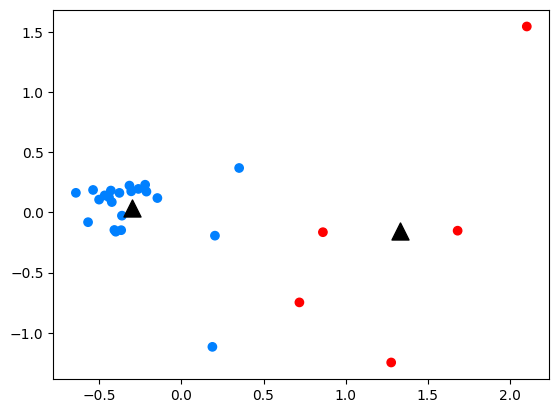

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
label1 = ["#FF0000", "#0080FF", "#0000FF", "#800080"]

color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

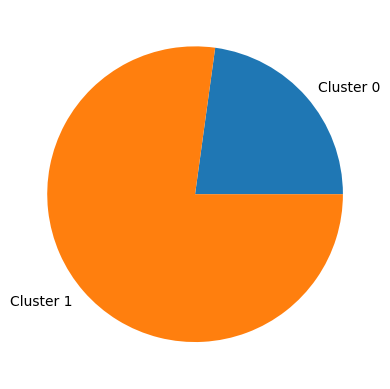

In [51]:
plt.pie(cluster_sums, labels=['Cluster ' + str(i) for i in range(n_clusters)])
plt.show()

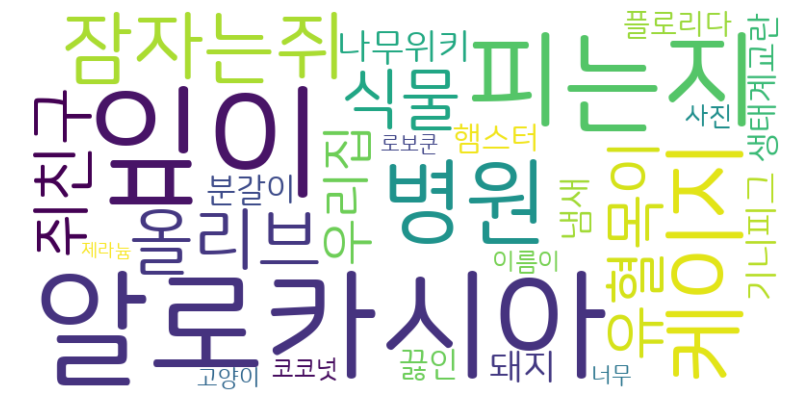

In [68]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, font_path='/content/drive/MyDrive/NanumSquareRoundR.ttf', background_color='white').generate_from_frequencies(dict(zip(selected_topic_names, post_counts)))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [71]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)

clustered_topics = [[] for _ in range(n_clusters)]
clustered_topics_name = [[] for _ in range(n_clusters)]
clustered_topics_count = [[] for _ in range(n_clusters)]

for i, label in enumerate(kmeans.labels_):
    clustered_topics[label].append(embed_ids[i])
    clustered_topics_name[label].append(selected_topic_names[i])
    clustered_topics_count[label].append(post_counts[i])

for r in clustered_topics_name:
    print(r)

['잎이', '식물']
['냄새', '끓인', '돼지']
['알로카시아', '피는지', '잠자는쥐', '케이지', '병원', '올리브', '쥐친구', '기니피그', '플로리다', '햄스터', '분갈이', '유혈목이', '이름이', '생태계교란', '나무위키', '고양이', '로보쿤', '우리집', '코코넛', '제라늄', '너무', '사진']


In [72]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

cluster_sums = []

for cluster in clustered_topics:
    total_sum = 0
    for parent_id in cluster:
        row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
        topic_ids = row['Topics']
        cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
        total_sum += cluster_sum
    cluster_sums.append(total_sum)

for idx, cluster_sum in enumerate(cluster_sums):
    print(f"Cluster {idx} contains {cluster_sum} documents.")


Cluster 0 contains 3609 documents.
Cluster 1 contains 739 documents.
Cluster 2 contains 14699 documents.


In [73]:
labels=kmeans.labels_.tolist()
pca = PCA(n_components=2).fit(embeddings)
datapoint = pca.transform(embeddings)

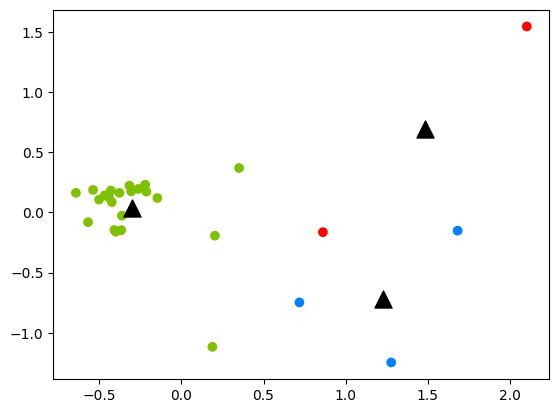

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
label1 = ["#FF0000", "#0080FF", "#80C000", "#800080"]

color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

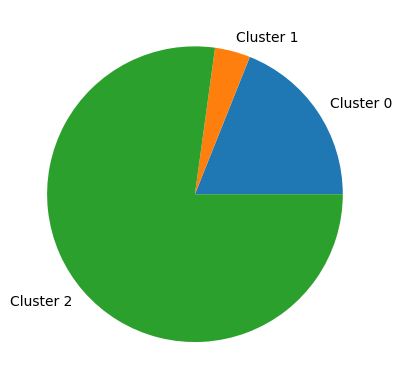

In [75]:
plt.pie(cluster_sums, labels=['Cluster ' + str(i) for i in range(n_clusters)])
plt.show()

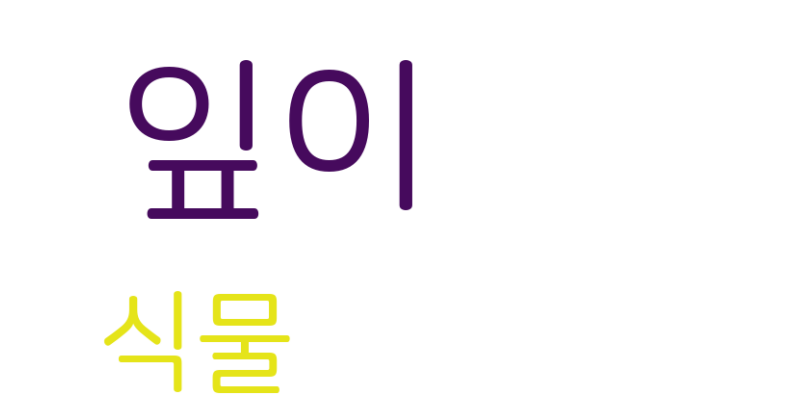

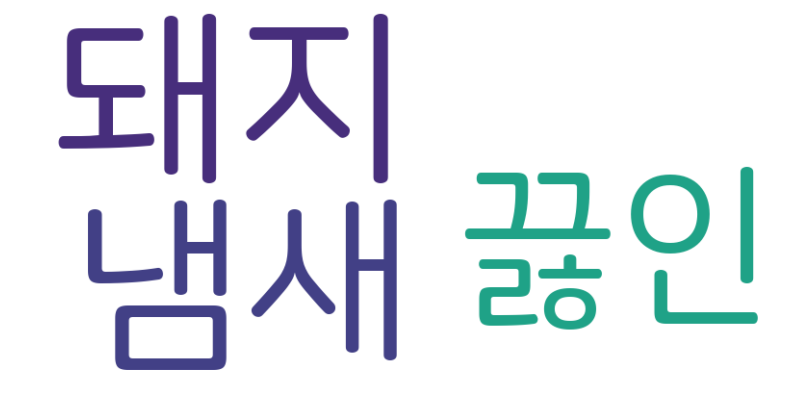

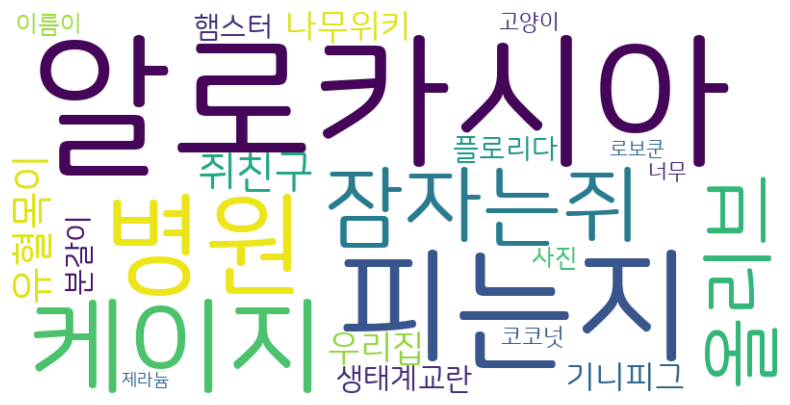

In [76]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i in range(n_clusters):
  text = ' '.join(clustered_topics_name[i])

  wordcloud = WordCloud(width=800, height=400, font_path='/content/drive/MyDrive/NanumSquareRoundR.ttf', background_color='white').generate_from_frequencies(dict(zip(clustered_topics_name[i], clustered_topics_count[i])))

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()